## Introduction

Consider the following system:
$$\frac{dx}{dt}=-x-y-x^{2}$$
$$\frac{dy}{dt}=x-y-y^{2}$$

We solve for equilibrium: $(0,0)$ and (numerical approximate) $(0.83928, -1.54368)$. By linearization near the equilibrium and computing the Jacobian matrix, $(0,0)$ is a spiral sink and $(0.83928, -1.54368)$ is a saddle. We are interested to approximate the basin of attraction of $(0,0)$.

In [5]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from scipy.integrate import solve_ivp

from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from tqdm import tqdm

In [6]:
## Bisection method to generate near-boundary points
def bisection(a, b, delta=0.01): ## a has label +1 and b has label -1
    distance = np.linalg.norm(np.array([a[0]-b[0], a[1]-b[1]]))
    if distance < delta:
        return (a, b)
    else:
        c = ((a[0]+b[0])/2, (a[1]+b[1])/2)
        if simulation(c[0], c[1]):
            return bisection(c, b, delta)
        else:
            return bisection(a, c, delta)

def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

spiral_sink = (0, 0)

# Check if the trajectory is attracted to the concerned spiral attractor
def is_attracted(x, y):
    return euclidean_distance((x, y), spiral_sink) < 1e-5

## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0):
    tmax, n = 1500, 100000
    soln = solve_ivp(system, (0, tmax), (x0, y0),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y= soln.sol(t)
    return is_attracted(x[n-1], y[n-1])


In [7]:
def system(t, X):
    x, y = X
    xp = -x-y-x*x
    yp = x-y-y*y
    return xp, yp

/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_83594/2502684936.py:7: RuntimeWarning: invalid value encountered in divide
  U = U / N
/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_83594/2502684936.py:8: RuntimeWarning: invalid value encountered in divide
  V = V / N


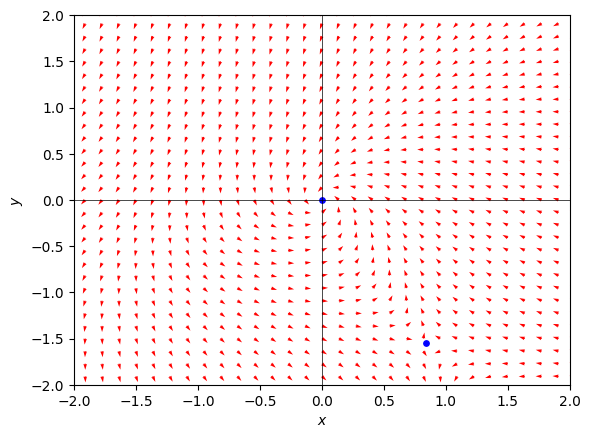

In [8]:
# Define the system of equations
Y, X = np.mgrid[-3:3:45j, -3:3:45j] 
U, V = system(0, (X, Y))

# Normalize arrows
N = np.sqrt(U**2 + V**2)
U = U / N
V = V / N

plt.quiver(X, Y, U, V, color='r')

# Highlight critical points
plt.scatter([0, 0.83928], [0, -1.54368], color='blue', s=15) 

# Add axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

plt.xlim([-2, 2])  # x-axis limits include negative values
plt.ylim([-2, 2])  # y-axis limits include negative values
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

## Model training: standard logistic regression

With traditional neural network classfier, we require good initial dataset to achieve good classification result. Suppose the dataset is of poor quality, such as the size is small/all datapoints are concentrated near the attractor, the performance will decay significantly. However, with our approach of data enhancement and adaptive training, we could enhance the dataset based on in-progress training result, reducing dependence on initial dataset. 

In [9]:
# Generate 1000 random points for each dimension
# X = np.random.uniform(-2, 2, 1000)
# Y = np.random.uniform(-2, 2, 1000)

# Create the dataset
# df = pd.DataFrame(columns=['x0', 'y0', 'attracted'])
# for i in tqdm(range(1000)):  # wrap range with tqdm for progress bar
#    x0, y0 = X[i], Y[i]
#    attracted_result = simulation(x0, y0)
#    attracted_result = 1 if attracted_result else -1  # map True to 1 and False to -1
#    df.loc[i] = [x0, y0, attracted_result]


# Save the DataFrame to a CSV file
# df.to_csv('dataset_arbi2d_1000.csv', index=False)

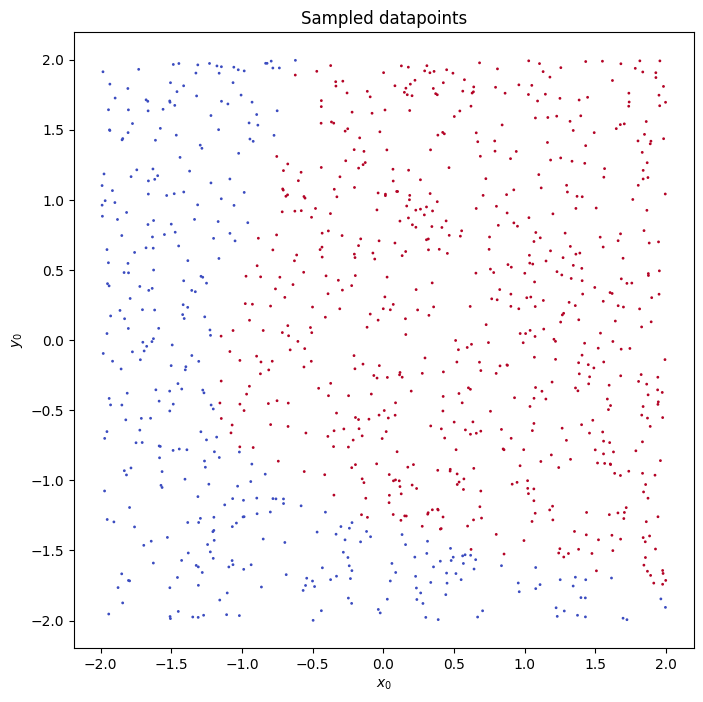

In [10]:
## Plot the sampled datapoints
df = pd.read_csv('dataset_arbi2d_1000.csv')
plt.figure(figsize=(8, 8))
plt.scatter(df['x0'], df['y0'], c=df['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Sampled datapoints')
plt.show()

In [52]:
class SystemDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data.iloc[idx, 0:2].values).float()
        y = torch.tensor(self.data.iloc[idx, 2]).float()
        return x, y
    
dataset_train = SystemDataset("dataset_arbi2d_1000.csv")


In [12]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2,32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    

In [13]:
def train_model_bce(net, dataset_train, batchsize, epochs, lr):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        #print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))
    return net

def test_model(net, dataset_test):
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0.5).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            # Move features, labels, and outputs to CPU and convert them to numpy arrays
            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 2D scatter plot
    #fig = plt.figure()
    #ax = fig.add_subplot(111)

    # Plot the features colored by the predictions
    #scatter = ax.scatter(features[:, 0], features[:, 1], c=probability, cmap='coolwarm')

    # Add a color bar
    #plt.colorbar(scatter)

    #plt.show()

    #plt.hist(probability, bins=20)
    #plt.show()
    return accuracy

In [14]:
net_1 = Net()
net_1 = train_model_bce(net_1, dataset_train, 32, 100, 0.001)

In [15]:
dataset_uniform_test = SystemDataset("dataset_arbi2d.csv")

In [16]:
test_model(net_1, dataset_uniform_test)

Accuracy: 0.9896900057792664


tensor(0.9897)

In [17]:
## We test the model by near-boundary points generated previously via bisection routine.
dataset_near_test = SystemDataset("dataset_arbi2d_near.csv")

In [18]:
test_model(net_1, dataset_near_test)

Accuracy: 0.5163000226020813


tensor(0.5163)

When the training set is small, we could see that the classifier does not give good performance if tested by points that are close to the boundary.

## Model training: data enhancement with near-boundaty points

In [128]:
df_data = dataset_train.data

df_data_1 = df_data[df_data['attracted'] == 1].sample(40)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(40)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
df_near.to_csv('dataset_arbi2d_enhanced_1600.csv', index=False)

Processing df_1: 100%|██████████| 40/40 [06:40<00:00, 10.02s/it]


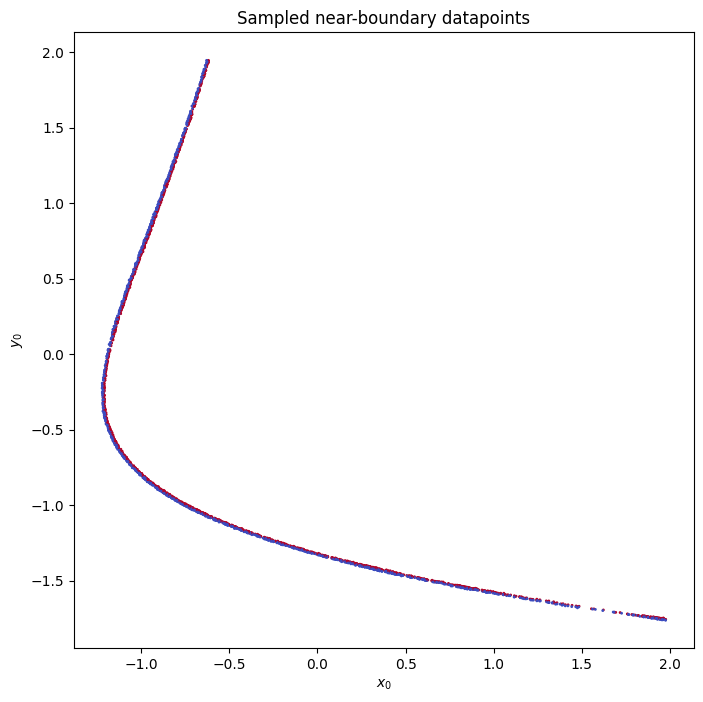

In [129]:
## Verify the generated near-boundary points
df_near = pd.read_csv('dataset_arbi2d_enhanced_1600.csv')
plt.figure(figsize=(8, 8))
plt.scatter(df_near['x0'], df_near['y0'], c=df_near['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Sampled near-boundary datapoints')
plt.show()

In [130]:
## Train the model again with enhanced dataset
dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_1600.csv")
dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])

In [140]:
net_2 = Net()
net_2 = train_model_bce(net_2, dataset_merged_train, 32, 100, 0.001)

In [141]:
test_model(net_2, dataset_uniform_test)

Accuracy: 0.9983400106430054


tensor(0.9983)

In [142]:
test_model(net_2, dataset_near_test)

Accuracy: 0.7145000100135803


tensor(0.7145)

We could see that with enhanced training set, we still retain good accuracy on universally-drawn test data, but achived improved accuracy on near-boundary test data as well.

## CustomLoss

We impose normality condition on near-boundary training points.

In [143]:
class SystemDatasetModified(Dataset):
    def __init__(self, csv_file, indicator):
        self.data = pd.read_csv(csv_file)
        self.indicator = indicator

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data.iloc[idx, 0:2].values).float()
        y = torch.tensor(self.data.iloc[idx, 2]).float()
        indicator = self.indicator
        return x, y, torch.tensor(indicator).float()
    
dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_1600.csv", 1)
dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])

    

In [144]:
class CustomLoss(nn.Module):
    def __init__(self, magnitude):
        super(CustomLoss, self).__init__()
        self.magnitude = magnitude

    def forward(self, predictions, labels, inputs, b, indicators):
        l = nn.BCELoss()(predictions.squeeze(), labels)

        # Compute gradient penalty only for data points with an indicator of 1
        for i, indicator in enumerate(indicators):
            if indicator == 1:
                grad_input = inputs[i].unsqueeze(0).clone().detach().requires_grad_(True)
                grad_prediction = predictions[i].unsqueeze(0)
                grads = torch.autograd.grad(grad_prediction.sum(), grad_input, create_graph=True, allow_unused=True)[0]
                
                if grads is not None:
                    norm_grads = grads / grads.norm(dim=1, keepdim=True)
                    norm_b = b[i].unsqueeze(0) / b[i].norm(dim=0, keepdim=True)
                    inner_product = (norm_grads * norm_b).sum(dim=1)** 2
                    l += self.magnitude * inner_product.sum()
        
        return l

def train_model_custom(net, dataset_train, batchsize, epochs, lr, magnitude):
    criterion = CustomLoss(magnitude)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels, indicators in dataloader_train: 
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels, features, system(0, features.T), indicators)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        
        #print(f'Finished training for epoch {epoch + 1}, loss: {running_loss / mini_batch_count:.3f}')
    
    return net

def test_model_modified(net, dataset_test):
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels, _ in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0.5).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            # Move features, labels, and outputs to CPU and convert them to numpy arrays
            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 2D scatter plot
    #fig = plt.figure()
    #ax = fig.add_subplot(111)

    # Plot the features colored by the predictions
    #scatter = ax.scatter(features[:, 0], features[:, 1], c=probability, cmap='coolwarm')

    # Add a color bar
    #plt.colorbar(scatter)

    #plt.show()

    #plt.hist(probability, bins=20)
    #plt.show()
    return accuracy

In [155]:
net_3 = Net()
net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, 10)

In [152]:
dataset_uniform_test_modified = SystemDatasetModified("dataset_arbi2d.csv", 0)
dataset_near_test_modified = SystemDatasetModified("dataset_arbi2d_near.csv", 1)

In [156]:
test_model_modified(net_3, dataset_uniform_test_modified)

Accuracy: 0.9978700280189514


tensor(0.9979)

In [157]:
test_model_modified(net_3, dataset_near_test_modified)

Accuracy: 0.6686499714851379


tensor(0.6686)

In [162]:
accuracy_uniform_1 = 0
accuracy_near_1 = 0
accuracy_uniform_2 = 0
accuracy_near_2 = 0
accuracy_uniform_3 = 0
accuracy_near_3 = 0

for i in range(10):
    print(f'Iteration {i + 1}')
    
    net_1 = Net()
    dataset_train_1 = SystemDataset("dataset_arbi2d_1000.csv")
    net_1 = train_model_bce(net_1, dataset_train_1, 32, 100, 0.001)

    net_2 = Net()
    dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
    dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_1600.csv")
    dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
    net_2 = train_model_bce(net_2, dataset_merged_train, 32, 100, 0.001)

    net_3 = Net()
    dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
    dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_1600.csv", 1)
    dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
    net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, 8442.813220061595)

    accuracy_uniform_1 += test_model(net_1, dataset_uniform_test)
    accuracy_near_1 += test_model(net_1, dataset_near_test)
    accuracy_uniform_2 += test_model(net_2, dataset_uniform_test)
    accuracy_near_2 += test_model(net_2, dataset_near_test)
    accuracy_uniform_3 += test_model_modified(net_3, dataset_uniform_test_modified)
    accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified)

print(f'Average accuracy for uniform test set with model 1: {accuracy_uniform_1 / 10}')
print(f'Average accuracy for near test set with model 1: {accuracy_near_1 / 10}')
print(f'Average accuracy for uniform test set with model 2: {accuracy_uniform_2 / 10}')
print(f'Average accuracy for near test set with model 2: {accuracy_near_2 / 10}')
print(f'Average accuracy for uniform test set with model 3: {accuracy_uniform_3 / 10}')
print(f'Average accuracy for near test set with model 3: {accuracy_near_3 / 10}')

Iteration 1
Accuracy: 0.995710015296936
Accuracy: 0.5703499913215637
Accuracy: 0.9985899925231934
Accuracy: 0.7597500085830688
Accuracy: 0.998769998550415
Accuracy: 0.7280499935150146
Iteration 2
Accuracy: 0.9957000017166138
Accuracy: 0.6208000183105469
Accuracy: 0.9971100091934204
Accuracy: 0.6136000156402588
Accuracy: 0.9978399872779846
Accuracy: 0.6050500273704529
Iteration 3
Accuracy: 0.9942399859428406
Accuracy: 0.5706999897956848
Accuracy: 0.9975000023841858
Accuracy: 0.5347999930381775
Accuracy: 0.9986500144004822
Accuracy: 0.6388499736785889
Iteration 4
Accuracy: 0.9933500289916992
Accuracy: 0.6016499996185303
Accuracy: 0.998199999332428
Accuracy: 0.5878999829292297
Accuracy: 0.9988099932670593
Accuracy: 0.7616999745368958
Iteration 5
Accuracy: 0.9924600124359131
Accuracy: 0.5188500285148621
Accuracy: 0.9973400235176086
Accuracy: 0.612500011920929
Accuracy: 0.9980400204658508
Accuracy: 0.696150004863739
Iteration 6
Accuracy: 0.992169976234436
Accuracy: 0.5425999760627747
Accura

In [169]:

accuracy_uniform_2 = 0
accuracy_near_2 = 0


for i in range(50):
    print(f'Iteration {i + 1}')
    
    net_2 = Net()
    dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
    dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_1600.csv")
    dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
    net_2 = train_model_bce(net_2, dataset_merged_train, 32, 100, 0.001)

    accuracy_uniform_2 += test_model(net_2, dataset_uniform_test)
    accuracy_near_2 += test_model(net_2, dataset_near_test)

print(f'Average accuracy for uniform test set with model 2: {accuracy_uniform_2 / 50}')
print(f'Average accuracy for near test set with model 2: {accuracy_near_2 / 50}')

Iteration 1
Accuracy: 0.999239981174469
Accuracy: 0.7630500197410583
Iteration 2
Accuracy: 0.9976199865341187
Accuracy: 0.5882999897003174
Iteration 3
Accuracy: 0.994979977607727
Accuracy: 0.583899974822998
Iteration 4
Accuracy: 0.9968400001525879
Accuracy: 0.5414000153541565
Iteration 5
Accuracy: 0.998170018196106
Accuracy: 0.7682999968528748
Iteration 6
Accuracy: 0.9972699880599976
Accuracy: 0.6180999875068665
Iteration 7
Accuracy: 0.9962000250816345
Accuracy: 0.5430999994277954
Iteration 8
Accuracy: 0.9985799789428711
Accuracy: 0.6601499915122986
Iteration 9
Accuracy: 0.9953200221061707
Accuracy: 0.5404999852180481
Iteration 10
Accuracy: 0.9980599880218506
Accuracy: 0.7085999846458435
Iteration 11
Accuracy: 0.9969099760055542
Accuracy: 0.5651999711990356
Iteration 12
Accuracy: 0.9953299760818481
Accuracy: 0.5565000176429749
Iteration 13
Accuracy: 0.9966999888420105
Accuracy: 0.5130500197410583
Iteration 14
Accuracy: 0.9962300062179565
Accuracy: 0.613099992275238
Iteration 15
Accurac

In [165]:
accuracy_uniform_3 = 0
accuracy_near_3 = 0

for i in range(50):
    print(f'Iteration {i + 1}')

    net_3 = Net()
    dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
    dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_1600.csv", 1)
    dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
    net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, 8442.813220061595)

    accuracy_uniform_3 += test_model_modified(net_3, dataset_uniform_test_modified)
    accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified)

print(f'Average accuracy for uniform test set with model 3: {accuracy_uniform_3 / 50}')
print(f'Average accuracy for near test set with model 3: {accuracy_near_3 / 50}')

Iteration 1
Accuracy: 0.9970200061798096
Accuracy: 0.6760500073432922
Iteration 2
Accuracy: 0.9986500144004822
Accuracy: 0.7248499989509583
Iteration 3
Accuracy: 0.9987199902534485
Accuracy: 0.7106500267982483
Iteration 4
Accuracy: 0.9966099858283997
Accuracy: 0.5823500156402588
Iteration 5
Accuracy: 0.9974499940872192
Accuracy: 0.7031499743461609
Iteration 6
Accuracy: 0.998449981212616
Accuracy: 0.7217000126838684
Iteration 7
Accuracy: 0.9980599880218506
Accuracy: 0.703249990940094
Iteration 8
Accuracy: 0.9989200234413147
Accuracy: 0.7368500232696533
Iteration 9
Accuracy: 0.9959200024604797
Accuracy: 0.5275999903678894
Iteration 10
Accuracy: 0.994700014591217
Accuracy: 0.5753999948501587
Iteration 11
Accuracy: 0.999180018901825
Accuracy: 0.8198500275611877
Iteration 12
Accuracy: 0.9981499910354614
Accuracy: 0.6625999808311462
Iteration 13
Accuracy: 0.9977899789810181
Accuracy: 0.6160500049591064
Iteration 14
Accuracy: 0.9980999827384949
Accuracy: 0.6165500283241272
Iteration 15
Accura

In [36]:
accuracy_uniform_1 = 0
accuracy_near_1 = 0
accuracy_uniform_2 = 0
accuracy_near_2 = 0
accuracy_uniform_3 = 0
accuracy_near_3 = 0

for i in range(50):
    print(f'Iteration {i + 1}')
    
    net_1 = Net()
    dataset_train_1 = SystemDataset("dataset_arbi2d_1000.csv")
    net_1 = train_model_bce(net_1, dataset_train_1, 32, 100, 0.001)

    net_2 = Net()
    dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
    dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_4900.csv")
    dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
    net_2 = train_model_bce(net_2, dataset_merged_train, 32, 100, 0.001)

    net_3 = Net()
    dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
    dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_4900.csv", 1)
    dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
    net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, 25)

    accuracy_uniform_1 += test_model(net_1, dataset_uniform_test)
    accuracy_near_1 += test_model(net_1, dataset_near_test)
    accuracy_uniform_2 += test_model(net_2, dataset_uniform_test)
    accuracy_near_2 += test_model(net_2, dataset_near_test)
    accuracy_uniform_3 += test_model_modified(net_3, dataset_uniform_test_modified)
    accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified)

print(f'Average accuracy for uniform test set with model 1: {accuracy_uniform_1 / 50}')
print(f'Average accuracy for near test set with model 1: {accuracy_near_1 / 50}')
print(f'Average accuracy for uniform test set with model 2: {accuracy_uniform_2 / 50}')
print(f'Average accuracy for near test set with model 2: {accuracy_near_2 / 50}')
print(f'Average accuracy for uniform test set with model 3: {accuracy_uniform_3 / 50}')
print(f'Average accuracy for near test set with model 3: {accuracy_near_3 / 50}')

Iteration 1
Accuracy: 0.9945700168609619
Accuracy: 0.5583999752998352
Accuracy: 0.9994300007820129
Accuracy: 0.8182500004768372
Accuracy: 0.9994900226593018
Accuracy: 0.8938000202178955
Iteration 2
Accuracy: 0.9892299771308899
Accuracy: 0.5213500261306763
Accuracy: 0.9988099932670593
Accuracy: 0.73580002784729
Accuracy: 0.9993199706077576
Accuracy: 0.8342000246047974
Iteration 3
Accuracy: 0.9943299889564514
Accuracy: 0.583299994468689
Accuracy: 0.9992499947547913
Accuracy: 0.8483499884605408
Accuracy: 0.9994199872016907
Accuracy: 0.8737499713897705
Iteration 4
Accuracy: 0.9931300282478333
Accuracy: 0.5387499928474426
Accuracy: 0.9995999932289124
Accuracy: 0.8414999842643738
Accuracy: 0.9993399977684021
Accuracy: 0.7878000140190125
Iteration 5
Accuracy: 0.9955700039863586
Accuracy: 0.5551499724388123
Accuracy: 0.9996299743652344
Accuracy: 0.8968999981880188
Accuracy: 0.9994300007820129
Accuracy: 0.824999988079071
Iteration 6
Accuracy: 0.9948499798774719
Accuracy: 0.5619500279426575
Accu

In [37]:
accuracy_uniform_1 = 0
accuracy_near_1 = 0
accuracy_uniform_2 = 0
accuracy_near_2 = 0
accuracy_uniform_3 = 0
accuracy_near_3 = 0

for i in range(50):
    print(f'Iteration {i + 1}')
    
    net_1 = Net()
    dataset_train_1 = SystemDataset("dataset_arbi2d_1000.csv")
    net_1 = train_model_bce(net_1, dataset_train_1, 32, 100, 0.001)

    net_2 = Net()
    dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
    dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_4900.csv")
    dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
    net_2 = train_model_bce(net_2, dataset_merged_train, 32, 100, 0.001)

    net_3 = Net()
    dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
    dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_4900.csv", 1)
    dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
    net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, 25.5)

    accuracy_uniform_1 += test_model(net_1, dataset_uniform_test)
    accuracy_near_1 += test_model(net_1, dataset_near_test)
    accuracy_uniform_2 += test_model(net_2, dataset_uniform_test)
    accuracy_near_2 += test_model(net_2, dataset_near_test)
    accuracy_uniform_3 += test_model_modified(net_3, dataset_uniform_test_modified)
    accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified)

print(f'Average accuracy for uniform test set with model 1: {accuracy_uniform_1 / 50}')
print(f'Average accuracy for near test set with model 1: {accuracy_near_1 / 50}')
print(f'Average accuracy for uniform test set with model 2: {accuracy_uniform_2 / 50}')
print(f'Average accuracy for near test set with model 2: {accuracy_near_2 / 50}')
print(f'Average accuracy for uniform test set with model 3: {accuracy_uniform_3 / 50}')
print(f'Average accuracy for near test set with model 3: {accuracy_near_3 / 50}')

Iteration 1
Accuracy: 0.996150016784668
Accuracy: 0.577049970626831
Accuracy: 0.998740017414093
Accuracy: 0.6790500283241272
Accuracy: 0.9990800023078918
Accuracy: 0.8640499711036682
Iteration 2
Accuracy: 0.989549994468689
Accuracy: 0.5606499910354614
Accuracy: 0.9987800121307373
Accuracy: 0.8617500066757202
Accuracy: 0.9994800090789795
Accuracy: 0.8593999743461609
Iteration 3
Accuracy: 0.9906399846076965
Accuracy: 0.5133500099182129
Accuracy: 0.999239981174469
Accuracy: 0.837149977684021
Accuracy: 0.9994500279426575
Accuracy: 0.8714500069618225
Iteration 4
Accuracy: 0.9940500259399414
Accuracy: 0.5437999963760376
Accuracy: 0.9991199970245361
Accuracy: 0.7748000025749207
Accuracy: 0.9994000196456909
Accuracy: 0.8615000247955322
Iteration 5
Accuracy: 0.9863600134849548
Accuracy: 0.5061500072479248
Accuracy: 0.9996899962425232
Accuracy: 0.9361000061035156
Accuracy: 0.9997900128364563
Accuracy: 0.9248999953269958
Iteration 6
Accuracy: 0.9879999756813049
Accuracy: 0.5133000016212463
Accura

In [38]:
accuracy_uniform_1 = 0
accuracy_near_1 = 0
accuracy_uniform_2 = 0
accuracy_near_2 = 0
accuracy_uniform_3 = 0
accuracy_near_3 = 0

for i in range(50):
    print(f'Iteration {i + 1}')
    
    net_1 = Net()
    dataset_train_1 = SystemDataset("dataset_arbi2d_1000.csv")
    net_1 = train_model_bce(net_1, dataset_train_1, 32, 100, 0.001)

    net_2 = Net()
    dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
    dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_4900.csv")
    dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
    net_2 = train_model_bce(net_2, dataset_merged_train, 32, 100, 0.001)

    net_3 = Net()
    dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
    dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_4900.csv", 1)
    dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
    net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, 26)

    accuracy_uniform_1 += test_model(net_1, dataset_uniform_test)
    accuracy_near_1 += test_model(net_1, dataset_near_test)
    accuracy_uniform_2 += test_model(net_2, dataset_uniform_test)
    accuracy_near_2 += test_model(net_2, dataset_near_test)
    accuracy_uniform_3 += test_model_modified(net_3, dataset_uniform_test_modified)
    accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified)

print(f'Average accuracy for uniform test set with model 1: {accuracy_uniform_1 / 50}')
print(f'Average accuracy for near test set with model 1: {accuracy_near_1 / 50}')
print(f'Average accuracy for uniform test set with model 2: {accuracy_uniform_2 / 50}')
print(f'Average accuracy for near test set with model 2: {accuracy_near_2 / 50}')
print(f'Average accuracy for uniform test set with model 3: {accuracy_uniform_3 / 50}')
print(f'Average accuracy for near test set with model 3: {accuracy_near_3 / 50}')

Iteration 1
Accuracy: 0.993340015411377
Accuracy: 0.5400500297546387
Accuracy: 0.9988499879837036
Accuracy: 0.6797999739646912
Accuracy: 0.9998000264167786
Accuracy: 0.9088000059127808
Iteration 2
Accuracy: 0.9850500226020813
Accuracy: 0.5058500170707703
Accuracy: 0.9990400075912476
Accuracy: 0.7760000228881836
Accuracy: 0.9995499849319458
Accuracy: 0.9150500297546387
Iteration 3
Accuracy: 0.9798499941825867
Accuracy: 0.5048999786376953
Accuracy: 0.9996899962425232
Accuracy: 0.8849499821662903
Accuracy: 0.9995599985122681
Accuracy: 0.9170500040054321
Iteration 4
Accuracy: 0.9925400018692017
Accuracy: 0.5586000084877014
Accuracy: 0.9997000098228455
Accuracy: 0.9140499830245972
Accuracy: 0.9993799924850464
Accuracy: 0.8296999931335449
Iteration 5
Accuracy: 0.9900299906730652
Accuracy: 0.526449978351593
Accuracy: 0.9993799924850464
Accuracy: 0.8971999883651733
Accuracy: 0.9997900128364563
Accuracy: 0.8999999761581421
Iteration 6
Accuracy: 0.9857500195503235
Accuracy: 0.5078999996185303
Ac

In [39]:
accuracy_uniform_1 = 0
accuracy_near_1 = 0
accuracy_uniform_2 = 0
accuracy_near_2 = 0
accuracy_uniform_3 = 0
accuracy_near_3 = 0

for i in range(50):
    print(f'Iteration {i + 1}')
    
    net_1 = Net()
    dataset_train_1 = SystemDataset("dataset_arbi2d_1000.csv")
    net_1 = train_model_bce(net_1, dataset_train_1, 32, 100, 0.001)

    net_2 = Net()
    dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
    dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_4900.csv")
    dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
    net_2 = train_model_bce(net_2, dataset_merged_train, 32, 100, 0.001)

    net_3 = Net()
    dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
    dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_4900.csv", 1)
    dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
    net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, 26.5)

    accuracy_uniform_1 += test_model(net_1, dataset_uniform_test)
    accuracy_near_1 += test_model(net_1, dataset_near_test)
    accuracy_uniform_2 += test_model(net_2, dataset_uniform_test)
    accuracy_near_2 += test_model(net_2, dataset_near_test)
    accuracy_uniform_3 += test_model_modified(net_3, dataset_uniform_test_modified)
    accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified)

print(f'Average accuracy for uniform test set with model 1: {accuracy_uniform_1 / 50}')
print(f'Average accuracy for near test set with model 1: {accuracy_near_1 / 50}')
print(f'Average accuracy for uniform test set with model 2: {accuracy_uniform_2 / 50}')
print(f'Average accuracy for near test set with model 2: {accuracy_near_2 / 50}')
print(f'Average accuracy for uniform test set with model 3: {accuracy_uniform_3 / 50}')
print(f'Average accuracy for near test set with model 3: {accuracy_near_3 / 50}')

Iteration 1
Accuracy: 0.9940599799156189
Accuracy: 0.5511000156402588
Accuracy: 0.9993299841880798
Accuracy: 0.8307499885559082
Accuracy: 0.999809980392456
Accuracy: 0.9386500120162964
Iteration 2
Accuracy: 0.9947599768638611
Accuracy: 0.5752000212669373
Accuracy: 0.9993600249290466
Accuracy: 0.8268499970436096
Accuracy: 0.9994900226593018
Accuracy: 0.8430500030517578
Iteration 3
Accuracy: 0.9890499711036682
Accuracy: 0.50204998254776
Accuracy: 0.9991599917411804
Accuracy: 0.7990000247955322
Accuracy: 0.9991499781608582
Accuracy: 0.7888500094413757
Iteration 4
Accuracy: 0.991890013217926
Accuracy: 0.5331000089645386
Accuracy: 0.9985899925231934
Accuracy: 0.6643499732017517
Accuracy: 0.9991400241851807
Accuracy: 0.786899983882904
Iteration 5
Accuracy: 0.9961900115013123
Accuracy: 0.6317499876022339
Accuracy: 0.9996700286865234
Accuracy: 0.8649500012397766
Accuracy: 0.9995499849319458
Accuracy: 0.8950499892234802
Iteration 6
Accuracy: 0.9960299730300903
Accuracy: 0.5607500076293945
Accur

KeyboardInterrupt: 

In [158]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Define the objective function for Bayesian Optimization
def objective_function(magnitude):
    accuracy_uniform_3 = 0
    accuracy_near_3 = 0
    
    for i in range(10):
        net_3 = Net()
        dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
        dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_1600.csv", 1)
        dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
        net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, magnitude)
        
        accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified).item()
    
    # Calculate average accuracy
    average_accuracy_near_3 = accuracy_near_3 / 10
    
    # Return negative accuracy because gp_minimize seeks to minimize the function
    return -average_accuracy_near_3

# Define the range for 'magnitude'
space = [Real(1, 10000, name='magnitude')]

# Use named args for convenience
@use_named_args(space)
def objective(**params):
    # Pass the entire params dictionary to the objective_function
    return objective_function(**params)

# Run Bayesian Optimization
result = gp_minimize(objective, space, n_calls=20, n_jobs=-1, random_state=0, verbose=True)

# Output the best result
print(f"Best magnitude: {result.x[0]}")
print(f"Best average accuracy: {-result.fun}")

Iteration No: 1 started. Evaluating function at random point.
Accuracy: 0.7409499883651733
Accuracy: 0.7269499897956848
Accuracy: 0.7598000168800354
Accuracy: 0.5336999893188477
Accuracy: 0.7387499809265137
Accuracy: 0.7094500064849854
Accuracy: 0.6463500261306763
Accuracy: 0.7635499835014343
Accuracy: 0.8128499984741211
Accuracy: 0.6789500117301941
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 308.8106
Function value obtained: -0.7111
Current minimum: -0.7111
Iteration No: 2 started. Evaluating function at random point.
Accuracy: 0.725350022315979
Accuracy: 0.8479499816894531
Accuracy: 0.7855499982833862
Accuracy: 0.6223499774932861
Accuracy: 0.6636499762535095
Accuracy: 0.7229499816894531
Accuracy: 0.8094499707221985
Accuracy: 0.7146000266075134
Accuracy: 0.6051999926567078
Accuracy: 0.8112499713897705
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 306.3306
Function value obtained: -0.7308
Current minimum: -0.7308
Iteration No: 3 started. Ev

/Users/keqinchen/Documents/GitHub/Estimate-Basin-Boundary/myenv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10000.0] before, using random point [8274.876786144683]
  warnings.warn(


Accuracy: 0.6692000031471252
Accuracy: 0.8511000275611877
Accuracy: 0.6335499882698059
Accuracy: 0.5438500046730042
Accuracy: 0.5275999903678894
Accuracy: 0.5065000057220459
Accuracy: 0.8881000280380249
Accuracy: 0.7264000177383423
Accuracy: 0.5521500110626221
Accuracy: 0.6692000031471252
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 309.4528
Function value obtained: -0.6568
Current minimum: -0.7308
Iteration No: 13 started. Searching for the next optimal point.
Accuracy: 0.8240500092506409
Accuracy: 0.5021499991416931
Accuracy: 0.6206499934196472
Accuracy: 0.7164499759674072
Accuracy: 0.6886000037193298
Accuracy: 0.6870999932289124
Accuracy: 0.6959999799728394
Accuracy: 0.7572000026702881
Accuracy: 0.5277000069618225
Accuracy: 0.7796000242233276
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 309.1500
Function value obtained: -0.6799
Current minimum: -0.7308
Iteration No: 14 started. Searching for the next optimal point

In [48]:
accuracy_uniform_3 = 0
accuracy_near_3 = 0

for i in range(10):
    print(f'Iteration {i + 1}')
    
    net_3 = Net()
    dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
    dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_3600.csv", 1)
    dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
    net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, 3875.3376068263037)

    accuracy_uniform_3 += test_model_modified(net_3, dataset_uniform_test_modified)
    accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified)


print(f'Average accuracy for uniform test set with model 3: {accuracy_uniform_3 / 10}')
print(f'Average accuracy for near test set with model 3: {accuracy_near_3 / 10}')

Iteration 1
Accuracy: 0.9995099902153015
Accuracy: 0.8644499778747559
Iteration 2
Accuracy: 0.9989500045776367
Accuracy: 0.6855000257492065
Iteration 3
Accuracy: 0.999210000038147
Accuracy: 0.7565500140190125
Iteration 4
Accuracy: 0.9993500113487244
Accuracy: 0.8305500149726868
Iteration 5
Accuracy: 0.9995800256729126
Accuracy: 0.8802000284194946
Iteration 6
Accuracy: 0.9981799721717834
Accuracy: 0.5772500038146973
Iteration 7
Accuracy: 0.9995899796485901
Accuracy: 0.8872500061988831
Iteration 8
Accuracy: 0.9992700219154358
Accuracy: 0.7829999923706055
Iteration 9
Accuracy: 0.9995999932289124
Accuracy: 0.8692499995231628
Iteration 10
Accuracy: 0.9994000196456909
Accuracy: 0.8287500143051147
Average accuracy for uniform test set with model 3: 0.9992640614509583
Average accuracy for near test set with model 3: 0.7962750196456909
